## **GA-CNN**

In [ ]:
# Define search space for hyperparameters
search_space = {
    "filters": [32, 64, 128, 256],
    "kernel_size": [3, 5, 7, 9],
    "pool_size": [2],
    "dense_units_1": [256, 512],
    "dense_units_2": [124, 256],
    "dropout_rate": [0.3, 0.5],
    "epochs": [5],
}

# Hyperparameters for GA
population_size = 2
num_generations = 4
mutation_rate = 0.2


# Fitness function
def fitness(model, X, y, v1, v2, alpha, beta, epsilon):
    loss, accuracy = model.evaluate(X, y, verbose=0)
    return alpha * accuracy * v1 + beta / (loss + epsilon) * v2


# Create CNN model based on hyperparameters
def create_cnn_model(
    filters,
    kernel_size,
    pool_size,
    dense_units_1,
    dense_units_2,
    dropout_rate,
    epochs,
    v1,
    v2,
    total_filters,
    total_kernels,
    total_neurons,
    total_epochs,
    fitness=0
):
    model = keras.Sequential()
    model.add(
        layers.Conv1D(
            filters=filters,
            kernel_size=(kernel_size,),
            activation="relu",
            input_shape=input_shape,
        )
    )
    model.add(
        layers.Conv1D(filters=filters, kernel_size=(kernel_size,), activation="relu")
    )
    model.add(layers.MaxPooling1D(pool_size=(pool_size,)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=dense_units_1, activation="relu"))
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.Dense(units=dense_units_2, activation="relu"))
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.Dense(num_classes, activation="softmax"))

    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    return model


# Function to calculate v1 and v2
def calculate_v1(individual):
    return (
        0.3 * (individual["filters"] / individual["total_filters"])
        + 0.3 * (individual["kernel_size"] / individual["total_kernels"])
        + 0.2 * (individual["dense_units_1"] / individual["total_neurons"])
        + 0.2 * (individual["total_epochs"] / 1.5)
    )


def calculate_v2(individual):
    return (
        0.3 * (1 - individual["filters"] / individual["total_filters"])
        + 0.3 * (1 - individual["kernel_size"] / individual["total_kernels"])
        + 0.2 * (1 - individual["dense_units_1"] / individual["total_neurons"])
        + 0.2 * (1 - individual["total_epochs"] / 1.5)
    )


# set a callback to automatically adjust learning rate
rlronp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)

# set a callback to stop training if the model is not improving for a long time
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,
    verbose=1,
    mode="auto",
)

# Main Genetic Algorithm
population = []

for _ in range(population_size):
    individual = {
        "filters": np.random.choice(search_space["filters"]),
        "kernel_size": np.random.choice(search_space["kernel_size"]),
        "pool_size": np.random.choice(search_space["pool_size"]),
        "dense_units_1": np.random.choice(search_space["dense_units_1"]),
        "dense_units_2": np.random.choice(search_space["dense_units_2"]),
        "dropout_rate": np.random.choice(search_space["dropout_rate"]),
        "epochs": np.random.choice(search_space["epochs"]),
        "v1": 0,
        "v2": 0,
        "total_filters": 0,
        "total_kernels": 0,
        "total_neurons": 0,
        "total_epochs": 0,
    }
    population.append(individual)

for generation in range(num_generations):
    print(f"Generation {generation + 1}/{num_generations}")

    for individual in population:
        model = create_cnn_model(**individual)
        model.fit(
            X_train,
            y_train,
            epochs=individual["epochs"],
            validation_split=0.2,
            verbose=1,
            callbacks=[rlronp, early_stop],
        )

        # Update total counts
        individual["total_filters"] += individual["filters"]
        individual["total_kernels"] += individual["kernel_size"]
        individual["total_neurons"] += individual["dense_units_1"]
        individual["total_epochs"] += individual["epochs"]

        # Update v1 and v2
        individual["v1"] = calculate_v1(individual)
        individual["v2"] = calculate_v2(individual)

        individual["fitness"] = fitness(
            model,
            X_test,
            y_test,
            v1=individual["v1"],
            v2=individual["v2"],
            alpha=0.99,
            beta=0.01,
            epsilon=1e-7,
        )

    # Select the top performers for the next generation
    population = sorted(population, key=lambda x: x["fitness"], reverse=True)[
        :population_size
    ]

    # Crossover
    new_population = copy.deepcopy(population)
    for i in range(0, len(population) - 1, 2):
        parent1 = population[i]
        parent2 = population[i + 1]
        child1 = {
            "filters": parent1["filters"],
            "kernel_size": parent2["kernel_size"],
            "pool_size": parent1["pool_size"],
            "dense_units_1": parent2["dense_units_1"],
            "dense_units_2": parent2["dense_units_2"],
            "dropout_rate": parent1["dropout_rate"],
            "epochs": parent2["epochs"],
            "v1": 0,
            "v2": 0,
            "total_filters": 0,
            "total_kernels": 0,
            "total_neurons": 0,
            "total_epochs": 0,
        }
        child2 = {
            "filters": parent2["filters"],
            "kernel_size": parent1["kernel_size"],
            "pool_size": parent2["pool_size"],
            "dense_units_1": parent1["dense_units_1"],
            "dense_units_2": parent1["dense_units_2"],
            "dropout_rate": parent2["dropout_rate"],
            "epochs": parent1["epochs"],
            "v1": 0,
            "v2": 0,
            "total_filters": 0,
            "total_kernels": 0,
            "total_neurons": 0,
            "total_epochs": 0,
        }
        new_population.append(child1)
        new_population.append(child2)

    # Mutation
    for individual in new_population:
        if np.random.rand() < mutation_rate:
            hyperparameter_to_mutate = np.random.choice(list(search_space.keys()))
            individual[hyperparameter_to_mutate] = np.random.choice(
                search_space[hyperparameter_to_mutate]
            )

    # Evaluate fitness for each individual in the new population
    for individual in new_population:
        model = create_cnn_model(**individual)
        model.fit( X_train,
            y_train, epochs=individual['epochs'], validation_split=0.2, verbose=1,callbacks=[rlronp,early_stop])

        # Update total counts
        individual['total_filters'] += individual['filters']
        individual['total_kernels'] += individual['kernel_size']
        individual['total_neurons'] += individual['dense_units_1']
        individual['total_epochs'] += individual['epochs']

        # Update v1 and v2
        individual['v1'] = calculate_v1(individual)
        individual['v2'] = calculate_v2(individual)

        individual['fitness'] = fitness(model, X_test, y_test,v1=individual['v1'],v2=individual['v2'],alpha=0.99,beta=0.01,epsilon = 1e-7)


    # Select the top performers for the next generation from the new population
    population = sorted(new_population, key=lambda x: x["fitness"], reverse=True)[
        :population_size
    ]

    # Print the best individual's fitness in this generation
    print("Best Fitness:", population[0]["fitness"])

# Retrieve the best hyperparameters
best_hyperparameters = population[0]
print("Best Hyperparameters:", best_hyperparameters)

Generation 1/4
Epoch 1/5
2840/2840 [==============================] - 49s 17ms/step - loss: 0.9207 - accuracy: 0.5524 - val_loss: 0.7548 - val_accuracy: 0.6448 - lr: 1.0000e-04
Epoch 2/5
2840/2840 [==============================] - 46s 16ms/step - loss: 0.7477 - accuracy: 0.6413 - val_loss: 0.7031 - val_accuracy: 0.6665 - lr: 1.0000e-04
Epoch 3/5
2840/2840 [==============================] - 46s 16ms/step - loss: 0.7172 - accuracy: 0.6554 - val_loss: 0.6917 - val_accuracy: 0.6740 - lr: 1.0000e-04
Epoch 4/5
 288/2840 [==>...........................] - ETA: 38s - loss: 0.7047 - accuracy: 0.6629

KeyboardInterrupt: 

In [ ]:
# Retrieve the best hyperparameters
best_hyperparameters = population[0]
print("Best Hyperparameters:", best_hyperparameters)

Best Hyperparameters: {'filters': 256, 'kernel_size': 3, 'pool_size': 2, 'dense_units_1': 256, 'dense_units_2': 256, 'dropout_rate': 0.5, 'epochs': 5, 'v1': 1.7333333333333334, 'v2': -0.7333333333333335, 'total_filters': 512, 'total_kernels': 6, 'total_neurons': 512, 'total_epochs': 10, 'fitness': 0.9805900054007768}


In [ ]:
best_ga_cnn= create_cnn_model(**best_hyperparameters)
best_ga_cnn.fit(X_train, y_train,epochs=10, batch_size=32,validation_split=0.2, verbose=1,callbacks=[rlronp,early_stop])

Epoch 1/10
3193/3193 [==============================] - ETA: 0s - loss: 0.8832 - accuracy: 0.5690

998/998 [==============================] - 15s 15ms/step
Accuracy: 0.62
Precision: 0.61
Recall: 0.62
F1 Score: 0.58
ROC-AUC: 0.79


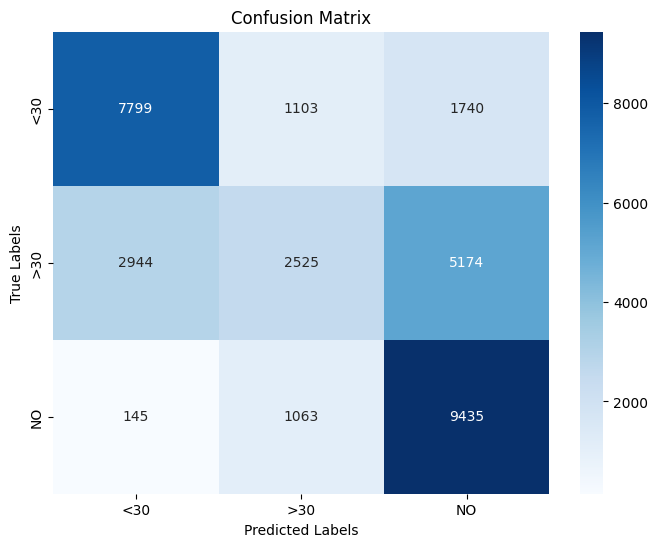

In [ ]:
# Evaluate the CNN model
y_pred_cnn_ga, y_pred_prob_cnn_ga, cnn_ga_metrics_list = evaluate_model(best_ga_cnn, X_test_bal, y_test_bal,cnn=True)